In [3]:
import gymnasium as gym
import numpy as np


class MyWrapper(gym.Wrapper):
    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()
env.reset()

array([0.00360215, 0.03866983, 0.02771687, 0.02592816], dtype=float32)

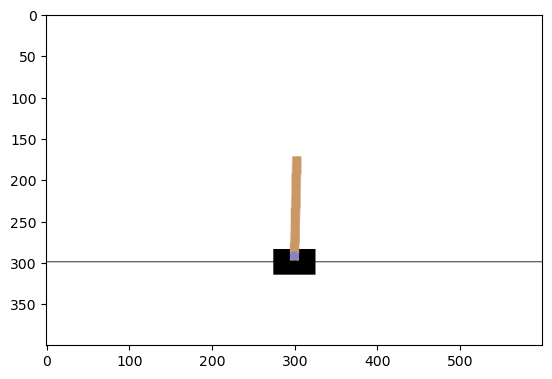

In [4]:
from matplotlib import pyplot as plt


def show():
    %matplotlib inline
    plt.imshow(env.render())
    plt.show()
    plt.clf()
show()

In [5]:
def test_env():
    state = env.reset()
    print("action", env.action_space.sample(), env.action_space)


test_env()


action 0 Discrete(2)


In [6]:
import torch

target_model = torch.nn.Sequential(torch.nn.Linear(4, 128),
                                   torch.nn.ReLU(),
                                   torch.nn.Linear(128, 2))
eval_model = torch.nn.Sequential(torch.nn.Linear(4, 128),
                                 torch.nn.ReLU(),
                                 torch.nn.Linear(128, 2))
target_model.load_state_dict(eval_model.state_dict())
target_model, eval_model


(Sequential(
   (0): Linear(in_features=4, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=2, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=2, bias=True)
 ))

In [7]:
import random


def get_action(state):
    if random.random() < 0.01:
        return random.choice([0, 1])
    state = torch.FloatTensor(state).reshape(1, 4)
    return eval_model(state).argmax().item()


get_action([0.0013847, -0.01194451, 0.04260966, 0.00688801])



0

In [10]:
#样本池
memory = []


def update_date():
    add_nums = 200
    old_count = len(memory)
    while len(memory) - old_count <= add_nums:
        #初始化
        state = env.reset()
        over = False
        while not over:
            action = get_action(state)
            next_state, reward, over, _ = env.step(action)
            if over==False:
                over=0
            else:
                over=1
            memory.append((state, action, reward, next_state, over))
            state = next_state
    while len(memory) > 10000:
        memory.pop(0)
update_date()

In [11]:
import numpy as np


#获取一批样本数据
def get_samples():
    samples = random.sample(memory, 64)
    state = torch.from_numpy(np.array([i[0] for i in samples]).reshape(-1, 4))
    action = torch.from_numpy(np.array([i[1] for i in samples]).reshape(-1, 1))
    reward = torch.from_numpy(np.array([i[2] for i in samples]).reshape(-1, 1))
    next_state = torch.from_numpy(np.array([i[3] for i in samples]).reshape(-1, 4))
    over = torch.from_numpy(np.array([i[4] for i in samples]).reshape(-1, 1))

    return state, action, reward, next_state, over
get_samples()

(tensor([[-1.7379e-03, -3.7215e-01, -2.6015e-02,  5.2846e-01],
         [-3.1554e-02, -6.1853e-01,  7.1392e-03,  8.9536e-01],
         [-1.0766e-02, -2.2881e-02,  2.3623e-02,  3.5924e-02],
         [ 1.2003e-02, -9.5818e-01,  3.5860e-02,  1.4029e+00],
         [ 3.8616e-02, -5.6779e-01, -2.5380e-03,  8.1402e-01],
         [-2.0519e-02, -7.6180e-01,  8.1071e-04,  1.1006e+00],
         [-2.3115e-02,  3.8781e-02, -3.4070e-02,  3.3074e-02],
         [ 4.8381e-02, -2.0202e-01,  1.6638e-02,  3.0756e-01],
         [ 2.4768e-02, -4.3856e-01, -3.1120e-03,  5.9587e-01],
         [-1.5646e-01, -1.7183e+00,  1.7958e-01,  2.7213e+00],
         [-3.2926e-02, -1.2151e+00,  6.4563e-02,  1.7472e+00],
         [-3.2673e-02, -1.3368e+00,  1.0243e-01,  2.0831e+00],
         [ 4.2741e-02, -4.3002e-01,  3.7392e-02,  6.3379e-01],
         [-1.7471e-01, -1.7465e+00,  1.9432e-01,  2.7493e+00],
         [-1.5148e-02, -1.2135e+00,  1.2494e-01,  1.8798e+00],
         [ 2.3032e-02, -8.1125e-01,  7.5336e-02,  1.208

In [ ]:
#计算模型认为的分数
def get_value(state, action):
    #state to logits
    value = eval_model(state)
    value = value.gather(dim=1, index=action)
    return value

In [ ]:
#计算真实的分数
def get_target_value(reward, next_state, over):
    with torch.no_grad():
        next_action_value = target_model(next_state)
    next_action_value = next_action_value.max(dim=1)[0]
    next_action_value = next_action_value.reshape(-1, 1)
    next_action_value*=(1-over)
    target_value = 0.98 * next_action_value + reward
    return target_value

In [ ]:
from IPython import display
import time
%matplotlib inline
def test(play):
    state=env.reset()
    reward_sum=0
    over=False
    while not over:
        action=get_action(state)
        state,reward,over,_,=env.step(action)
        reward_sum+=reward
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()
            time.sleep(1)
    return reward_sum

In [ ]:
def train():
    eval_model.train()
    optimizer = torch.optim.Adam(eval_model.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()
    for epoch in range(100):
        update_date()
        for i in range(200):
            #采样
            state, action, reward, next_state, over = get_samples()
            #计算一批样本的value和target_value
            value = get_value(state, action)
            target_value = get_target_value(reward, next_state, over)
            #更新参数
            loss=loss_fn(value.float(),target_value.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #把eval_model的参数复制给target_model
            if (i+1)%10==0:
                target_model.load_state_dict(eval_model.state_dict())
        if (epoch+1) % 50 == 0:
            test_result = sum([test(play=False) for _ in range(20)]) / 20
            print(epoch, len(memory), test_result)
train()
            